In [ ]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()

## Stable Diffusion

In [ ]:
!nvidia-smi

Thu May 18 12:57:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install diffusers==0.11.1
!pip install transformers scipy ftfy accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.1 MB/s eta 0:00:00


In [ ]:
import torch
from diffusers import StableDiffusionPipeline
import numpy as np

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)  

Fetching 20 files:   0%|          | 0/20 [00:00<?, ?it/s]

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [ ]:
pipe = pipe.to("cuda")

  0%|          | 0/50 [00:00<?, ?it/s]

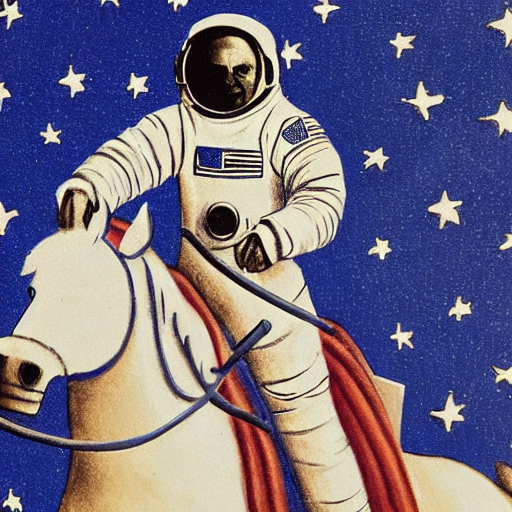

In [ ]:
prompt = "a student of an astronaut riding a horse"
image = pipe(prompt).images[0]  # image here is in [PIL format](https://pillow.readthedocs.io/en/stable/)

# Now to display an image you can either save it such as:
# image.save(f"astronaut_rides_horse.png")

# or if you're in a google colab you can directly display it with 
image

In [ ]:
""" 
# TODO
input : 32개의 text가 존재하는 list -> real_sentence 
output : tensor   (Size([32, 3, 512, 512]))
"""
import re

# 문자열 반환
def keep_until_eos(sentence):
    pattern = r"(.*?)<eos>"
    match = re.search(pattern, sentence)
    if match:
        return match.group(1).strip()
    else:
        return ""

def transform_real_sentence(batch):
  real_sentences = []
  for i in range(batch.shape[1]):
    temp = [textField.vocab.itos[token] for token in batch[1:, i]] # 문장
    real_sentence = " ".join(temp)
    real_sentences.append(keep_until_eos(real_sentence)) #배치안에 i번째 문장 1/32
    # real_sentences.append(keep_until_eos(temp)) #배치안에 i번째 문장 1/32
  return real_sentences


# real 문장 리스트 > tensor
def transform_tensor(real_sentence): 
  image_list = []
  for prompt in real_sentence:
    image = pipe(prompt).images[0]
    image = image.convert("RGB")
    image_np = np.array(image)
    image_list.append(image_np)  # image_list 배열에 추가

    image_arr = np.stack(image_list, axis=0) # 이미지 리스트를 numpy 배열로 변환합니다.
    tensor = torch.from_numpy(image_arr.transpose((0, 3, 1, 2))) # 이미지 배열을 torch.Tensor로 변환합니다.
  return tensor


## Imports

In [ ]:
!pip install torchtext==0.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.6 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.1
    Uninstalling torchtext-0.15.1:
      Successfully uninstalled torchtext-0.15.1


In [ ]:
# general
import time
import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt

# pytorch
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.nn import TransformerDecoder, TransformerDecoderLayer
from torch.utils.data import DataLoader
import torchtext
from torchtext.data import Field, BucketIterator
from torchtext.datasets import Multi30k

# constant seed
seed = 41
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

print("Importing finished")

Importing finished


In [ ]:
print(torchtext.__version__)

0.6.0


In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.data import Field

## Helper Functions

In [ ]:
def data2sentences(data, name='PTB', subset_size=5000):
    sentence_data = []
    cur_sentence = []
    text = data.examples[0].text

    if name == 'PTB':
        for i, word in enumerate(text):
              if word == '<eos>':
                  sentence_data.append(cur_sentence)
                  cur_sentence = []
              else:
                  cur_sentence.append(word)
    
    if name == 'WikiText2': # TODO: better parsing into sentences
        for i, word in enumerate(text):
            if ((word == '.' and (len(text[i+1]) != 1 or text[i+1] in ['a', 'i']) 
                             and (len(text[i-1]) != 1 or text[i-1] in [')', ']', '}']))
                             and (text[i-1] not in ['mr', 'mrs', 'dr', 'jr', 'prof', 'op'])
                or word in ['<eos>', '?', '!']):
                sentence_data.append(cur_sentence)
                cur_sentence = []
            elif word != "=":
                cur_sentence.append(word)
    ramdom_sentence_data = random.sample(sentence_data, k=subset_size)
    # print(ramdom_sentence_data[:50])
    return ramdom_sentence_data

def preprocess_text(name, dataset, textField, max_len=50, plot=False, subset_size = 5000):
    sentences_raw = data2sentences(dataset, name, subset_size)
     
    #################
    if plot:
        sentence_length = [len(t) for t in sentences_raw]
        plt.hist(sentence_length, bins=84)
        plt.title("Sentence Length Distribution - Before Filter")
        plt.show()
    #################
    
    sentences_filtered = []
    for i in range(len(sentences_raw)):
      if 3 <= len(sentences_raw[i]) <= max_len:
        sentences_filtered.append(sentences_raw[i])
    
    #################
    if plot:
        print("\n")
        sentence_length = [len(t) for t in sentences_filtered]
        plt.hist(sentence_length, bins=43)
        plt.title("Sentence Length Distribution - After Filter")
        plt.show()
    #################
    
    sentences = textField.pad(sentences_filtered)
    sentences = textField.numericalize(sentences)
    return sentences[:, 1:]

def pad_token_sen(token_sen, max_sen_len, pad_idx):
    pad_add = torch.full((1, max_sen_len - len(token_sen) + 2), pad_idx).to(device)
    token_sen = token_sen.transpose(0,1)
    out = torch.cat((token_sen, pad_add), 1)
    out = out.transpose(1,0)
    return out

def create_masks(batch, pad_token):
    pad_mask = (batch == pad_token).transpose(0, 1)

    seq_len = batch.shape[0]
    mask = (torch.triu(torch.ones((seq_len, seq_len), device=batch.device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))

    return pad_mask, mask

def calc_kl(mu, logvar, reduce='mean'):
    kl = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).sum(1)
    if reduce == 'sum':
        kl = torch.sum(kl)
    elif reduce == 'mean':
        kl = torch.mean(kl)
    return kl

def cyc_beta_scheduler(epochs, warmup_epochs, beta_min, beta_max, period, ratio):
    beta_warmup = np.ones(warmup_epochs) * beta_min
    beta_cyc = np.ones(epochs - warmup_epochs) * beta_max
    n_cycle = int(np.floor((epochs - warmup_epochs)/period))
    step = (beta_max - beta_min)/(period * ratio)
    for c in range(n_cycle):
        curr_beta, i = beta_min, 0
        while curr_beta <= beta_max and (int(i + c*period) < epochs - warmup_epochs):
              beta_cyc[int(i + c*period)] = curr_beta
              curr_beta += step
              i += 1
    beta = np.concatenate((beta_warmup, beta_cyc), axis=0)
    return beta

## TransformerVAE Definition

In [ ]:
# Building Blocks
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=50, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class Word2SentenceEmbedding(nn.Module):
    def __init__(self, hdim):
        super(Word2SentenceEmbedding, self).__init__()
        self.dense = nn.Linear(hdim, hdim)
        self.activation = nn.Tanh()
 
    def forward(self, hidden_states):
        # take the hidden state corresponding to <sos> token
        first_token_tensor = hidden_states[0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output


# Encoder
class Encoder(nn.Module):
    def __init__(self, ntokens, e_dim=200, z_dim=32, nheads=4, nTlayers=4, ff_dim=400, pad_idx=1):
        super(Encoder, self).__init__()
        self.e_dim = e_dim

        self.embedding = nn.Embedding(ntokens, e_dim, padding_idx=pad_idx)
        self.pos_encoding = PositionalEncoding(e_dim)
        encoder_layers = TransformerEncoderLayer(d_model=e_dim, nhead=nheads, dim_feedforward=ff_dim, dropout=0.2)
        self.transformer_encoder = TransformerEncoder(encoder_layer=encoder_layers, num_layers=nTlayers)
        self.word2sen_hidden = Word2SentenceEmbedding(hdim=e_dim)
        self.hid2latparams = nn.Linear(e_dim, 2*z_dim)

    def forward(self, sentences, pad_mask):
        embedded = self.embedding(sentences) * math.sqrt(self.e_dim)
        embedded = self.pos_encoding(embedded)
        hidden = self.transformer_encoder(embedded, src_key_padding_mask=pad_mask)
        hidden = self.word2sen_hidden(hidden)
        y = self.hid2latparams(hidden)
        mu, logvar = y.chunk(2, dim=1)
        return mu, logvar

# Decoder
class Decoder(nn.Module):
    def __init__(self, ntokens, e_dim=256, z_dim=32, nheads=4, nTlayers=4, ff_dim=1024, pad_idx=1):
        super(Decoder, self).__init__()
        self.e_dim = e_dim

        self.embedding = nn.Embedding(ntokens, e_dim, padding_idx=pad_idx)
        self.pos_encoding = PositionalEncoding(e_dim)
        self.lat2hid = nn.Linear(z_dim, e_dim)
        decoder_layers = TransformerDecoderLayer(d_model=e_dim, nhead=nheads, dim_feedforward=ff_dim, dropout=0.2)
        self.transformer_decoder = TransformerDecoder(decoder_layer=decoder_layers, num_layers=nTlayers)
        self.hid2logits = nn.Linear(e_dim, ntokens)

    def forward(self, z, sentences, tgt_mask, tgt_pad_mask):
        memories = self.lat2hid(z)
        memories = memories.unsqueeze(0)
        embedded_targets = self.embedding(sentences) * math.sqrt(self.e_dim)
        embedded_targets = self.pos_encoding(embedded_targets)
        
        hidden = self.transformer_decoder(embedded_targets, memories, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_pad_mask)
        logits = self.hid2logits(hidden)
        return logits

# TransformerVAE
class TransformerVAE(nn.Module):
    def __init__(self, ntokens, e_dim=256, z_dim=32, nheads=4, ff_dim=1024, nTElayers=4, nTDlayers=4, pad_idx=1):
        super(TransformerVAE, self).__init__()
        self.z_dim = z_dim
        self.encoder = Encoder(ntokens, e_dim, z_dim, nheads, nTElayers, ff_dim, pad_idx)
        self.decoder = Decoder(ntokens, e_dim, z_dim, nheads, nTDlayers, ff_dim, pad_idx)

    def forward(self, sentences, pad_mask, tgt_mask):
        mu, logvar = self.encoder(sentences, pad_mask)
        z = self.reparameterize(mu, logvar)
        logits = self.decoder(z, sentences, tgt_mask, pad_mask)
        return mu, logvar, logits

    def reparameterize(self, mu, logvar):
        # apply the reparameterization trick
        device = mu.device
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std).to(device)
        return mu + eps * std

    def encode(self, sentence, pad_token=1):
        sentence = sentence.to(device)
        pad_mask = (sentence == pad_token).transpose(0, 1)
        mu, logvar = self.encoder(sentence, pad_mask)
        z = self.reparameterize(mu, logvar)
        return z
    
    def generate(self, z=None, device="cpu", max_sen_len=50, sos_idx=2, eos_idx=3, policy='greedy', k=10):
        if z is None: # sample z ~ N(0,I)
            z = torch.randn(self.z_dim).unsqueeze(0).to(device)
        next_word_probs = []

        # first target is <sos>
        sen = torch.ones(1, 1).fill_(sos_idx).type(torch.long).to(device)
        for i in range(max_sen_len-1):
            # create mask
            mask = (torch.triu(torch.ones((len(sen), len(sen)), device=device)) == 1).transpose(0, 1)
            mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
            # decode
            out = self.decoder(z, sen, tgt_mask=mask, tgt_pad_mask=None)
            next_word_prob = out[-1].squeeze()

            # TODO: implement 'topP' and 'beam_search' policies
            if policy == 'topK':
                topk_values, topk_tokens = torch.topk(next_word_prob, k)
                topk_probs = torch.exp(topk_values) / torch.sum(torch.exp(topk_values)) # softmax
                idx = torch.multinomial(topk_probs, 1).item()
                next_word = topk_tokens[idx].item()

            elif policy == 'multinomial':
                next_word_prob_softmax = torch.exp(next_word_prob) / torch.sum(torch.exp(next_word_prob)) # softmax
                next_word = torch.multinomial(next_word_prob_softmax, 1)
                next_word = next_word.item()

            else: # 'greedy'
                next_word = torch.argmax(next_word_prob)
                next_word = next_word.item()
              
            # add decoded word to sentence
            sen = torch.cat([sen, torch.ones(1, 1).fill_(next_word).type(torch.long).to(device)], dim=0)
            next_word_probs.append(next_word_prob)
            if next_word == eos_idx:
                break
        return sen, next_word_probs

    def reconstruct(self, sen_orig, device="cpu", max_sen_len=50, pad_idx=1, 
                    sos_idx=2, eos_idx=3, policy='greedy', k=4):
        # encode original sentence to latent space representation
        z = self.encode(sen_orig, pad_idx)  # def encode(self, sentence, pad_token)
        # decode from latent space
        sen_rec, _ = self.generate(z, device, max_sen_len, sos_idx, eos_idx, policy, k)
        return sen_rec

    def interpolate(self, sen_1=None, sen_2=None, intervals=10, device="cpu", 
                    max_sen_len=50, pad_idx=1, sos_idx=2, eos_idx=3, policy='greedy', k=4):
        if sen_1 is not None: # encode
            z_1 = self.encode(sen_1, pad_idx)
        else: # sample z ~ N(0,I)
            z_1 = torch.randn(self.z_dim).unsqueeze(0).to(device)
        
        if sen_2 is not None: # encode
            z_2 = self.encode(sen_2, pad_idx)
        else: # sample z ~ N(0,I)
            z_2 = torch.randn(self.z_dim).unsqueeze(0).to(device)

        sentences = []
        for i in range(intervals+1):
            t = i / intervals
            z = z_1 * (1-t) + z_2 * t
            sen, _ = self.generate(z, device, max_sen_len, sos_idx, eos_idx, policy, k)
            sentences.append(sen.squeeze())
        
        return sentences

## Model Definition and Training

In [ ]:
# Choose Dataset: ['PTB', 'WikiText2']
dataset = 'PTB'

### Preparing the Data

In [ ]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")
textField = Field(sequential=True, init_token='<sos>', eos_token='<eos>', lower=True, tokenize=tokenizer)

In [ ]:
# Initialize tokenizer and text field
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")
textField = Field(sequential=True, init_token='<sos>', eos_token='<eos>', lower=True, tokenize=tokenizer)

# Load and split dataset
dataset = 'PTB'  # Choose the dataset you want to use: 'PTB' or 'WikiText2'
if dataset == 'PTB':  # PennTreebank
    train_set, valid_set, test_set = torchtext.datasets.PennTreebank.splits(textField)
elif dataset == 'WikiText2':  # WikiText-2
    train_set, valid_set, test_set = torchtext.datasets.WikiText2.splits(textField)
else:
    raise NotImplementedError("Dataset is not supported")


# Build a vocabulary
textField.build_vocab(train_set)
pad_idx = textField.vocab.stoi['<pad>']
sos_idx = textField.vocab.stoi['<sos>']
eos_idx = textField.vocab.stoi['<eos>']
len_vocab = len(textField.vocab)
print(f'Size of vocabulary: {len_vocab}\n')

# Pre-process data into tokenized padded sentences
max_sen_len = 45
sentence_data = preprocess_text(dataset, train_set, textField, max_len=max_sen_len, plot=False, subset_size=300)
num_sentences = sentence_data.shape[1]
print(f'\nNumber of sentences in train set: {num_sentences}')

sentence_data_validation = preprocess_text(dataset, valid_set, textField, max_len=max_sen_len, subset_size=30)
num_validation_sentences = sentence_data_validation.shape[1]
print(f'\nNumber of sentences in validation set: {num_validation_sentences}')

sentence_data_test = preprocess_text(dataset, test_set, textField, max_len=max_sen_len, subset_size=30)
num_test_sentences = sentence_data_test.shape[1]
print(f'\nNumber of sentences in test set: {num_test_sentences}\n\n')

# Print sentence samples from dataset
random_sample_indices = np.random.randint(0, sentence_data.shape[1], size=4)
for i, s in enumerate(random_sample_indices):
    eos_i = max_sen_len + 2
    for idx, token in enumerate(sentence_data[:, s]):
        if token == textField.vocab.stoi["<eos>"]:
            eos_i = idx
            break
    sentence = " ".join([textField.vocab.itos[t] for t in sentence_data[1:eos_i, s]])
    print(f"train sample #{s}: {sentence}\n")

downloading ptb.train.txt


ptb.train.txt: 5.10MB [00:00, 79.4MB/s]                   


downloading ptb.valid.txt


ptb.valid.txt: 400kB [00:00, 18.1MB/s]                   


downloading ptb.test.txt


ptb.test.txt: 450kB [00:00, 19.7MB/s]                   


Size of vocabulary: 9925


Number of sentences in train set: 290

Number of sentences in validation set: 28

Number of sentences in test set: 28


train sample #80: brokerage houses are sweet on h&r block too

train sample #243: but he refused claiming that he wanted to see what happened monday morning before making any public statement

train sample #89: mr . smith ' s managers have at times been called <unk> <unk> <unk> ' s guerrillas

train sample #282: the results reflected a n n gain in income from its finance businesses and a n n slide in income from insurance operations



### Hyperparameters

In [ ]:
# Model parameters
ntokens = len_vocab
e_dim = 512
ff_dim = 4 * e_dim
nheads = 8
nTElayers = 4
nTDlayers = 4
z_dim = 32

# Training parameters
num_epochs = 30
batch_size = 32
lr = 0.1
milestones = [20, ]
# beta related
beta_sch = 'anneal' # ['cyclic', 'anneal', 'constant']
beta_warmup = 4 # num warmup epochs
beta_min = 0.005
beta_max = 0.04
beta_period = 8 # relevent for 'cyclic' scheduler
ratio = 0.75

### Model, Loss, Optimizer, Schedulers

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = TransformerVAE(ntokens, e_dim, z_dim, nheads, ff_dim, nTElayers, nTDlayers, pad_idx).to(device)
rec_criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

if beta_sch == 'cyclic':
    beta_scheduler = cyc_beta_scheduler(epochs=num_epochs, warmup_epochs=beta_warmup, 
                                        beta_min=beta_min, beta_max=beta_max, period=beta_period, ratio=ratio)
elif beta_sch == 'anneal':
    beta_scheduler = cyc_beta_scheduler(epochs=num_epochs, warmup_epochs=beta_warmup, 
                                        beta_min=beta_min, beta_max=beta_max, period=num_epochs-beta_warmup, ratio=ratio)
else:  # 'constant'
    beta_scheduler = np.concatenate((beta_min * np.ones(beta_warmup), beta_max * np.ones(num_epochs-beta_warmup)))
beta = beta_scheduler[0]

# print(model)

In [ ]:
# code 추가

import torch
import torch.nn as nn
import torchvision.models as cnn_models
# ShuffleNet 모델을 불러옵니다.


# model 변경
# cnn_model = cnn_models.squeezenet1_0(pretrained=True)
cnn_model = cnn_models.mobilenet_v3_small(pretrained=True)  # 가장 적게 됬음.
# cnn_model = cnn_models.shufflenet_v2_x0_5(pretrained=True)

#cnn_model = cnn_models.mobilenet_v2(pretrained=True)
#cnn_model = cnn_models.vgg16(pretrained=True)
#cnn_model = cnn_models.resnet50(pretrained=True)
# ShuffleNet 모델의 마지막 convolutional layer를 제거합니다.
cnn_modules = list(cnn_model.children())[:-1]
cnn_model = nn.Sequential(*cnn_modules)
# Building Blocks

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 77.7MB/s]


In [ ]:
# Calculate number of parameters in model
dummy_model = TransformerVAE(ntokens, e_dim, z_dim, nheads, ff_dim, nTElayers, nTDlayers, pad_idx)
num_trainable_params = sum([p.numel() for p in dummy_model.parameters() if p.requires_grad])
print("Total number of parameters: ", num_trainable_params)

Total number of parameters:  44992773


### Training

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
new_path = "/content/drive/MyDrive"
os.chdir(new_path)

In [ ]:
# Initialize stats and related values
rec_loss_log = []
kl_loss_log = []
bVAE_loss_log = [] # rec_loss + beta * kl_loss
log_interval = math.floor((num_sentences / batch_size) / 5)
save_interval = 5
epoch_model_path = []

# Wrap datasets with DataLoader
sentences = sentence_data.transpose(0,1)
batch_loader = DataLoader(sentences, batch_size=batch_size, shuffle=True, drop_last=True)
sentences_validation = sentence_data_validation.transpose(0,1)
validation_batch_loader = DataLoader(sentences_validation, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(1, num_epochs + 1):
    model.train()
    total_rec_loss = 0.
    total_kl_loss = 0.
    total_bVAE_loss = 0.
    total_rec_loss_valid = 0.
    total_kl_loss_valid = 0.
    start_time = time.time()

    for i, batch in enumerate(batch_loader):
        batch = batch.transpose(0,1).to(device)
        pad_mask, tgt_mask = create_masks(batch, pad_token=pad_idx)
        # forward pass
        mu, logvar, logits = model(batch, pad_mask, tgt_mask)

        ########################################################################
        # x_train 데이터를 모델에 통과시켜서 출력되는 feature map의 크기를 확인합니다.

        ### TODO : Difussion model
        x = torch.rand((32, 3, 512, 512))
        ###
        output_conv = cnn_model(x)

        # feature map의 크기를 32x64로 만들기 위해서 global average pooling을 적용합니다.
        avgpool = nn.AdaptiveAvgPool2d((1, 1))
        output_conv = avgpool(output_conv)

        # 마지막 feature map을 32x64 크기로 바꿔줍니다.
        flatten = nn.Flatten()
        dense1 = nn.Linear(1024, 256)
        dense2 = nn.Linear(256, 64)
        output_conv = flatten(output_conv)
        output_conv = dense1(output_conv)
        output_conv = dense2(output_conv)
 
        mu2, logvar2=output_conv.chunk(2, dim=1)
        mu2 = mu2.to(device)
        logvar2 = logvar2.to(device)
        mu=mu+mu2
        logvar=logvar+logvar2
        ########################################################################
        # loss calculation
        rec_loss = rec_criterion(logits[:-1,:,:].view(-1, ntokens), batch[1:,:].flatten())
        kl_loss = calc_kl(mu, logvar)
        bVAE_loss = rec_loss + beta * kl_loss
        # backward pass
        optimizer.zero_grad()
        bVAE_loss.backward()
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        # update parameters
        optimizer.step()

        # gather and print stats
        total_rec_loss  += rec_loss.item()
        total_kl_loss   += kl_loss.item()
        total_bVAE_loss += bVAE_loss.item()

        if epoch == 1 and i == 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | lr {:02.4f} | beta {:02.4f} | ms/batch {:5.2f} | rec_loss {:5.4f} | kl_loss {:5.4f} | bVAE_loss {:5.4f} |'.format(
                    epoch, i, len(batch_loader), lr_scheduler.get_last_lr()[0], beta, elapsed * 1000 / log_interval,
                    rec_loss, kl_loss, bVAE_loss))
        
        if i % log_interval == 0 and i > 0:
            cur_rec_loss  = total_rec_loss  / log_interval
            cur_kl_loss   = total_kl_loss   / log_interval
            cur_bVAE_loss = total_bVAE_loss / log_interval

            rec_loss_log.append(cur_rec_loss)
            kl_loss_log.append(cur_kl_loss)
            bVAE_loss_log.append(cur_bVAE_loss)
          
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | lr {:02.4f} | beta {:02.4f} | ms/batch {:5.2f} | rec_loss {:5.4f} | kl_loss {:5.4f} | bVAE_loss {:5.4f} |'.format(
                    epoch, i, len(batch_loader), lr_scheduler.get_last_lr()[0], beta, elapsed * 1000 / log_interval, cur_rec_loss, cur_kl_loss, cur_bVAE_loss))
            
            total_rec_loss = 0.
            total_kl_loss = 0.
            total_bVAE_loss = 0.
            start_time = time.time()

    # update learning rate
    lr_scheduler.step()
    # update beta
    if epoch < num_epochs:
        beta = beta_scheduler[epoch]

    # evaluate model on validation set
    if epoch % save_interval == 0 or epoch == num_epochs :
        model.eval()
        print("\nEvaluating model on validation set...")
        for i, batch in enumerate(validation_batch_loader):
            batch = batch.transpose(0,1).to(device)
            pad_mask, tgt_mask = create_masks(batch, pad_token=pad_idx)
            # forward pass
            mu, logvar, logits = model(batch, pad_mask, tgt_mask)
            # loss calculation
            rec_loss_valid = rec_criterion(logits[:-1,:,:].view(-1, ntokens), batch[1:,:].flatten())
            kl_loss_valid = calc_kl(mu, logvar)
            total_rec_loss_valid += rec_loss_valid.item()
            total_kl_loss_valid  += kl_loss_valid.item()

        mean_rec_loss_valid = total_rec_loss_valid / len(validation_batch_loader)
        mean_kl_loss_valid = total_kl_loss_valid / len(validation_batch_loader)
        perplexity = math.exp(mean_rec_loss_valid)
        print('| validation_rec_loss {:5.4f} | validation_kl_loss {:5.4f} | validation_perplexity {:5.2f} |'.format(mean_rec_loss_valid, mean_kl_loss_valid, perplexity))
        
        total_rec_loss_valid = 0.
        total_kl_loss_valid  = 0.
        model.train()

    # TODO : 모델 중간 저장
    # save model
    print("\n")
    if epoch % save_interval == 0 or epoch == num_epochs :
        print('Saving model ...\n')
        path = './checkpoints/TransformerVAE_{}_epoch_{:3d}_rec_{:5.4f}_kl_{:5.4f}_valid_perp_{:5.2f}.pth'.format(dataset, epoch, cur_rec_loss, cur_kl_loss, perplexity)
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        epoch_model_path.append(path)
        torch.save(model.state_dict(), path)

print('\n Finished training')

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
[['they', 'increased', 'the', 'after-tax', 'rate', 'of', 'return', 'and', 'made', 'britain', 'a', 'far', 'more', 'attractive', 'place', 'to', 'invest', 'producing', 'sudden', 'capital', 'inflows', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['for', 'the', 'nine', 'months', 'the', 'company', 'expects', 'to', 'post', 'a', 'net', 'loss', '

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 16>:40                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1501 in _call_impl            │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217 in forward             │
│                                                                                                  │
│   214 │   # with Any as TorchScript expects a more precise type                                  │
│   215 │   def forward(self, input):                                                              │
│   216 │   │   for module in self:                                                                │
│ ❱ 217 │   │   │   input = module(input)                                                          │
│   218 │   │   return input                                                                       │
│   219 │                                                                                          │
│   220 │   def append(self, module: Module) -> 'Sequential':                                      │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1501 in _call_impl            │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217 in forward             │
│                                                                                                  │
│   214 │   # with Any as TorchScript expects a more precise type                                  │
│   215 │   def forward(self, input):                                                              │
│   216 │   │   for module in self:                                                                │
│ ❱ 217 │   │   │   input = module(input)                                                          │
│   218 │   │   return input                                 

In [ ]:
## test code

# Initialize stats and related values
rec_loss_log = []
kl_loss_log = []
bVAE_loss_log = [] # rec_loss + beta * kl_loss
log_interval = math.floor((num_sentences / batch_size) / 5)
save_interval = 5
epoch_model_path = []

# Wrap datasets with DataLoader
sentences = sentence_data.transpose(0,1)
batch_loader = DataLoader(sentences, batch_size=batch_size, shuffle=True, drop_last=True)
sentences_validation = sentence_data_validation.transpose(0,1)
validation_batch_loader = DataLoader(sentences_validation, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(1, 1 + 1):
    model.train()
    total_rec_loss = 0.
    total_kl_loss = 0.
    total_bVAE_loss = 0.
    total_rec_loss_valid = 0.
    total_kl_loss_valid = 0.
    start_time = time.time()

    for i, batch in enumerate(batch_loader):
        batch = batch.transpose(0,1).to(device)
        pad_mask, tgt_mask = create_masks(batch, pad_token=pad_idx)
        # forward pass
        mu, logvar, logits = model(batch, pad_mask, tgt_mask)

        ########################################################################
        # x_train 데이터를 모델에 통과시켜서 출력되는 feature map의 크기를 확인합니다.
        ### TODO : Difussion model
        # x = torch.rand((32, 3, 512, 512))
        x = transform_real_sentence(batch)
        x = transform_tensor(x)
        x = x.float()

        ###
        output_conv = cnn_model(x)

        # feature map의 크기를 32x64로 만들기 위해서 global average pooling을 적용합니다.
        avgpool = nn.AdaptiveAvgPool2d((1, 1))
        output_conv = avgpool(output_conv)

        # 마지막 feature map을 32x64 크기로 바꿔줍니다.
        flatten = nn.Flatten()
        dense1 = nn.Linear(576, 256)
        dense2 = nn.Linear(256, 64)
        output_conv = flatten(output_conv)
        output_conv = dense1(output_conv)
        output_conv = dense2(output_conv)
 
        mu2, logvar2=output_conv.chunk(2, dim=1)
        mu2 = mu2.to(device)
        logvar2 = logvar2.to(device)
        mu=mu+mu2
        logvar=logvar+logvar2
        ########################################################################
        # loss calculation
        rec_loss = rec_criterion(logits[:-1,:,:].view(-1, ntokens), batch[1:,:].flatten())
        kl_loss = calc_kl(mu, logvar)
        bVAE_loss = rec_loss + beta * kl_loss
        # backward pass
        optimizer.zero_grad()
        bVAE_loss.backward()
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        # update parameters
        optimizer.step()

        # gather and print stats
        total_rec_loss  += rec_loss.item()
        total_kl_loss   += kl_loss.item()
        total_bVAE_loss += bVAE_loss.item()

        if epoch == 1 and i == 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | lr {:02.4f} | beta {:02.4f} | ms/batch {:5.2f} | rec_loss {:5.4f} | kl_loss {:5.4f} | bVAE_loss {:5.4f} |'.format(
                    epoch, i, len(batch_loader), lr_scheduler.get_last_lr()[0], beta, elapsed * 1000 / log_interval,
                    rec_loss, kl_loss, bVAE_loss))
        
        if i % log_interval == 0 and i > 0:
            cur_rec_loss  = total_rec_loss  / log_interval
            cur_kl_loss   = total_kl_loss   / log_interval
            cur_bVAE_loss = total_bVAE_loss / log_interval

            rec_loss_log.append(cur_rec_loss)
            kl_loss_log.append(cur_kl_loss)
            bVAE_loss_log.append(cur_bVAE_loss)
          
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | lr {:02.4f} | beta {:02.4f} | ms/batch {:5.2f} | rec_loss {:5.4f} | kl_loss {:5.4f} | bVAE_loss {:5.4f} |'.format(
                    epoch, i, len(batch_loader), lr_scheduler.get_last_lr()[0], beta, elapsed * 1000 / log_interval, cur_rec_loss, cur_kl_loss, cur_bVAE_loss))
            
            total_rec_loss = 0.
            total_kl_loss = 0.
            total_bVAE_loss = 0.
            start_time = time.time()

    # update learning rate
    lr_scheduler.step()
    # update beta
    if epoch < num_epochs:
        beta = beta_scheduler[epoch]

    # evaluate model on validation set
    if epoch % save_interval == 0 or epoch == num_epochs :
        model.eval()
        print("\nEvaluating model on validation set...")
        for i, batch in enumerate(validation_batch_loader):
            batch = batch.transpose(0,1).to(device)
            pad_mask, tgt_mask = create_masks(batch, pad_token=pad_idx)
            # forward pass
            mu, logvar, logits = model(batch, pad_mask, tgt_mask)
            # loss calculation
            rec_loss_valid = rec_criterion(logits[:-1,:,:].view(-1, ntokens), batch[1:,:].flatten())
            kl_loss_valid = calc_kl(mu, logvar)
            total_rec_loss_valid += rec_loss_valid.item()
            total_kl_loss_valid  += kl_loss_valid.item()

        mean_rec_loss_valid = total_rec_loss_valid / len(validation_batch_loader)
        mean_kl_loss_valid = total_kl_loss_valid / len(validation_batch_loader)
        perplexity = math.exp(mean_rec_loss_valid)
        print('| validation_rec_loss {:5.4f} | validation_kl_loss {:5.4f} | validation_perplexity {:5.2f} |'.format(mean_rec_loss_valid, mean_kl_loss_valid, perplexity))
        
        total_rec_loss_valid = 0.
        total_kl_loss_valid  = 0.
        model.train()

    # TODO : 모델 중간 저장
    # save model
    print("\n")
    if epoch % save_interval == 0 or epoch == num_epochs :
        print('Saving model ...\n')
        path = './checkpoints/TransformerVAE_{}_epoch_{:3d}_rec_{:5.4f}_kl_{:5.4f}_valid_perp_{:5.2f}.pth'.format(dataset, epoch, cur_rec_loss, cur_kl_loss, perplexity)
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        epoch_model_path.append(path)
        torch.save(model.state_dict(), path)

print('\n Finished training')

0번 구간 성공
배치사이즈 torch.Size([47, 32])


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 18>:54                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1501 in _call_impl            │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/nn/modules/linear.py:114 in forward                │
│                                                                                                  │
│   111 │   │   │   init.uniform_(self.bias, -bound, bound)                                        │
│   112 │                                                                                          │
│   113 │   def forward(self, input: Tensor) -> Tensor:                                            │
│ ❱ 114 │   │   return F.linear(input, self.weight, self.bias)                                     │
│   115 │                                                                                          │
│   116 │   def extra_repr(self) -> str:                                                           │
│   117 │   │   return 'in_features={}, out_features={}, bias={}'.format(                          │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x576 and 1024x256)

In [ ]:
""" 
# TODO 추가한 함수 코드들
"""
import re

# 문자열 반환
def keep_until_eos(sentence):
    pattern = r"(.*?)<eos>"
    match = re.search(pattern, sentence)
    if match:
        return match.group(1).strip()
    else:
        return ""

def transform_real_sentence(batch):
  real_sentences = []
  for i in range(32):
    temp = [textField.vocab.itos[token] for token in batch[1:, i]] # 문장
    real_sentences.append(temp) #배치안에 i번째 문장 1/32
    # real_sentences.append(keep_until_eos(temp)) #배치안에 i번째 문장 1/32
  return real_sentences


# real 문장 리스트 > tensor
def transform_tensor(real_sentence): 
  image_list = []
  for prompt in real_sentence:
    image = pipe(prompt).images[0]
    image = image.convert("RGB")
    image_np = np.array(image)
    image_list.append(image_np)  # image_list 배열에 추가

    image_arr = np.stack(image_list, axis=0) # 이미지 리스트를 numpy 배열로 변환합니다.
    tensor = torch.from_numpy(image_arr.transpose((0, 3, 1, 2))) # 이미지 배열을 torch.Tensor로 변환합니다.
  return tensor


In [ ]:
## test code

# Initialize stats and related values
rec_loss_log = []
kl_loss_log = []
bVAE_loss_log = [] # rec_loss + beta * kl_loss
log_interval = math.floor((num_sentences / batch_size) / 5)
save_interval = 5
epoch_model_path = []

# Wrap datasets with DataLoader
sentences = sentence_data.transpose(0,1)
batch_loader = DataLoader(sentences, batch_size=batch_size, shuffle=True, drop_last=True)
sentences_validation = sentence_data_validation.transpose(0,1)
validation_batch_loader = DataLoader(sentences_validation, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(1, 1 + 1):
    model.train()
    total_rec_loss = 0.
    total_kl_loss = 0.
    total_bVAE_loss = 0.
    total_rec_loss_valid = 0.
    total_kl_loss_valid = 0.
    start_time = time.time()

    for i, batch in enumerate(batch_loader):
        batch = batch.transpose(0,1).to(device)
        pad_mask, tgt_mask = create_masks(batch, pad_token=pad_idx)
        # forward pass
        mu, logvar, logits = model(batch, pad_mask, tgt_mask)

        ########################################################################
        # x_train 데이터를 모델에 통과시켜서 출력되는 feature map의 크기를 확인합니다.

        ### TODO : Difussion model
        # x = torch.rand((32, 3, 512, 512))
        x = transform_real_sentence(batch)
        x = transform_tensor(x)
        # print(x)
        ###
        # output_conv = cnn_model(x)

        # # feature map의 크기를 32x64로 만들기 위해서 global average pooling을 적용합니다.
        # avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # output_conv = avgpool(output_conv)

        # # 마지막 feature map을 32x64 크기로 바꿔줍니다.
        # flatten = nn.Flatten()
        # dense1 = nn.Linear(1024, 256)
        # dense2 = nn.Linear(256, 64)
        # output_conv = flatten(output_conv)
        # output_conv = dense1(output_conv)
        # output_conv = dense2(output_conv)
 
        # mu2, logvar2=output_conv.chunk(2, dim=1)
        # mu2 = mu2.to(device)
        # logvar2 = logvar2.to(device)
        # mu=mu+mu2
        # logvar=logvar+logvar2
        ########################################################################
         

  0%|          | 0/50 [00:00<?, ?it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 18>:39                                                                            │
│ in transform_tensor:28                                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py:115 in decorate_context       │
│                                                                                                  │
│   112 │   @functools.wraps(func)                                                                 │
│   113 │   def decorate_context(*args, **kwargs):                                                 │
│   114 │   │   with ctx_factory():                                                                │
│ ❱ 115 │   │   │   return func(*args, **kwargs)                                                   │
│   116 │                                                                                          │
│   117 │   return decorate_context                                                                │
│   118                                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_dif │
│ fusion.py:529 in __call__                                                                        │
│                                                                                                  │
│   526 │   │   │   │   latent_model_input = self.scheduler.scale_model_input(latent_model_input   │
│   527 │   │   │   │                                                                              │
│   528 │   │   │   │   # predict the noise residual                                               │
│ ❱ 529 │   │   │   │   noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text   │
│   530 │   │   │   │                                                                              │
│   531 │   │   │   │   # perform guidance                                                         │
│   532 │   │   │   │   if do_classifier_free_guidance:                                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1501 in _call_impl            │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/diffusers/models/unet_2d_condition.py:424 in forward     │
│                                                                                                  │
│   421 │   │   down_block_res_samples = (sample,)                                                 │
│   422 │   │   for downsample_block in self.down_blocks:                                          │
│   423 │   │   │   if hasattr(downsample_block, "has_cross_a

### Loss curves

In [ ]:
# Plot loss curves
fig, axes = plt.subplots(1, 3, figsize=(17,5))
axes[0].plot(np.arange(len(rec_loss_log)), rec_loss_log)
axes[0].set_title('Reconstruction Loss')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel(f'Log Interval ({log_interval} batches)')
axes[1].plot(np.arange(len(kl_loss_log)), kl_loss_log)
axes[1].set_title('KL Loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel(f'Log Interval ({log_interval} batches)')
axes[2].plot(np.arange(len(bVAE_loss_log)), bVAE_loss_log)
axes[2].set_title('beta-VAE Loss')
axes[2].set_ylabel('Loss')
axes[2].set_xlabel(f'Log Interval ({log_interval} batches)')
plt.show()

## Trained Model Results

### Load Model from Checkpoint

In [ ]:
from google.colab import drive
# Choose checkpoint origin: ['drive', 'notebook']
origin = 'drive'

In [ ]:
if origin == 'drive':
    drive.mount('/content/drive') # give notebook access to google drive to load/save checkpoints
    base_path = './checkpoints/' # enter path where checkpoint is saved, example: './drive/checkpoints/'
    checkpoint = 'TransformerVAE_PTB_epoch_ 30_rec_4.pth'          # enter checkpoint name, example: 'TransformerVAE_PTB_epoch_ 20_rec_2.5473_kl_7.8348_valid_perp_105.44.pth'
    # path = base_path + checkpoint
    # path = "/content/checkpoints/TransformerVAE_PTB_epoch_ 30_rec_4.9509_kl_0.4467_valid_perp_1471.70.pth"
    path = "/content/drive/MyDrive/checkpoints/TransformerVAE_PTB_epoch_  5_rec_6.6447_kl_1.1202_valid_perp_933.24.pth"
  
# elif origin == 'notebook':
#     path = epoch_model_path[-1] # take last saved checkpoint in training (can choose other)

else:
    raise NotImplementedError("Checkpoint origin is not supported")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load trained model
trained_model = TransformerVAE(ntokens, e_dim, z_dim, nheads, ff_dim, nTElayers, nTDlayers, pad_idx).to(device)
trained_model.load_state_dict(torch.load(path, map_location=torch.device(device)))
trained_model.eval()

print("Succesfully loaded model from checkpoint")

Succesfully loaded model from checkpoint


### Test Perplexity

In [ ]:
# Wrap dataset with DataLoader
test_sentences = sentence_data_test.transpose(0,1)
test_batch_loader = DataLoader(test_sentences, batch_size=batch_size, shuffle=True)

# Calculate perplexity
total_rec_loss = 0.
for i, batch in enumerate(test_batch_loader):
    batch = batch.transpose(0,1).to(device)
    pad_mask, tgt_mask = create_masks(batch, pad_token=pad_idx)
    # forward pass
    mu, logvar, logits = trained_model(batch, pad_mask, tgt_mask)
    # loss calculation
    rec_loss = rec_criterion(logits[:-1,:,:].view(-1, ntokens), batch[1:,:].flatten())
    total_rec_loss += rec_loss.item()

mean_rec_loss = total_rec_loss / len(test_batch_loader)
perplexity = math.exp(mean_rec_loss)
print('Test perplexity: {:5.2f}'.format(perplexity))

Test perplexity: 1160.63


In [ ]:
sentence_data_test

tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [   4,   32,  929,  ...,    4,  799,   20],
        [ 476, 2107,   18,  ...,  593,  846,    4],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]])

### Sentence Generation

In [ ]:
# token_sen, next_word_probs = generate(trained_model, None, z_dim, device, max_sen_len, sos_idx, eos_idx, policy='topK', k=10)
token_sen, next_word_probs = trained_model.generate(None, device, max_sen_len, sos_idx, eos_idx, policy='topK', k=3)
sentence = " ".join([textField.vocab.itos[t] for t in token_sen[1:-1]])
print(f"Generated sentence of length {len(token_sen)-2}: {sentence}\n")

Generated sentence of length 1: <unk>



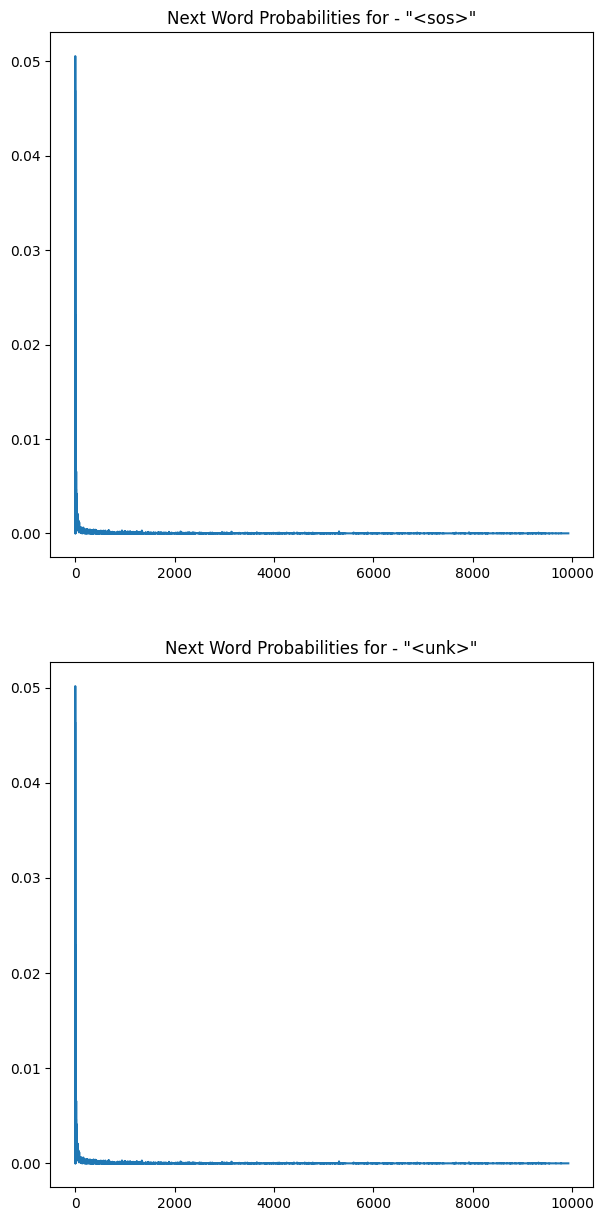

In [ ]:
# Plot next word probabilities for each word in generated sentence 
word = []
prob = []

for i in range(len(token_sen)):
  word.append(" ".join([textField.vocab.itos[t] for t in token_sen[i]]))
  if i < len(token_sen)-1:
      prob.append(next_word_probs[i].detach().cpu().numpy())

prob = np.exp(prob) / np.sum(np.exp(prob)) # softmax

fig, axes = plt.subplots(len(token_sen)-1, figsize=(7,5*len(token_sen)))
for i in range(len(token_sen)): 
  if i < len(token_sen)-1:
    axes[i].plot(prob[i])
    axes[i].set_title('Next Word Probabilities for - \"{}\"'.format(word[i]))

plt.show()

### Sentence Reconstruction

In [ ]:
# Choose source of sentence to reconstruct: ['random', 'validset', 'custom']
sen_src = 'random'

# if 'validset' choose sample index or None to randomly select an index:
sample_idx = None
# if 'custom', provide sentence in seperated string list in list format (i.e [[<strings seperated by ,>]]):
custom_sen = [['i', 'think', 'i', 'want', 'water']]

In [ ]:
# prepare sentence
if sen_src == 'random': # generate sentence by sampling z ~ N(0,I)
    token_sen, _ = trained_model.generate(None, device, max_sen_len, sos_idx, eos_idx, policy='topK', k=50)
    # token_sen, _ = trained_model.generate(None, device, max_sen_len, sos_idx, eos_idx, policy='greedy', k=1)
    sentence = " ".join([textField.vocab.itos[t] for t in token_sen[1:-1]])
    token_sen = pad_token_sen(token_sen, max_sen_len, pad_idx)

elif sen_src == 'validset': # take sentence from training set
    if sample_idx is None:
        idx = np.random.randint(0, sentence_data_validation.shape[1], size=1)
    else:
        idx = sample_idx

    eos_i = max_sen_len + 2
    for i, token in enumerate(sentence_data_validation[:, idx]):
        if token == textField.vocab.stoi["<eos>"]:
            eos_i = i
            break
    sentence = " ".join([textField.vocab.itos[t] for t in sentence_data_validation[1:eos_i, idx]])
    token_sen = sentence_data_validation[:, idx]
    
elif sen_src == 'custom':
    sentence = " ".join(custom_sen[0])
    token_sen = textField.pad(custom_sen)
    token_sen = textField.numericalize(token_sen)

else:
    raise NotImplementedError("Sentence source is not supported")

# reconstruct
token_sen_rec = trained_model.reconstruct(token_sen, device, max_sen_len, pad_idx, sos_idx, eos_idx, policy='greedy', k=1)
sentence_reconstructed = " ".join([textField.vocab.itos[t] for t in token_sen_rec[1:-1]])
print('Original sentence:      ', sentence)
print('Reconstructed sentence: ', sentence_reconstructed)

Original sentence:       for new
Reconstructed sentence:  


### Interpolation between Sentences in Latent Space

In [ ]:
# Choose source of sentences to interpolate between: ['random', 'trainset', 'custom']
sen_src_1 = 'trainset'
sen_src_2 = 'trainset'

# if 'trainset' choose sample index or None to randomly select an index:
sample_idx_1 = None
sample_idx_2 = None
# if 'custom', provide sentence in seperated string list in list format (i.e [[<strings seperated by ,>]]):
custom_sen_1 = [['i', 'think', 'therefore', 'i', 'am']]
custom_sen_2 = [['all', 'happy', 'families', 'are', 'alike']]

In [ ]:
# prepare sentence 1
if sen_src_1 == 'random': # generate sentence by sampling z ~ N(0,I)
    sen_1 = None

elif sen_src_1 == 'trainset': # take sentence from training set
    if sample_idx_1 is None:
        idx = np.random.randint(0, sentence_data.shape[1], size=1)
    else:
        idx = sample_idx_1
    sen_1 = sentence_data[:, idx]
    
elif sen_src_1 == 'custom':
    sen_1 = textField.pad(custom_sen_1)
    sen_1 = textField.numericalize(sen_1)

else:
    raise NotImplementedError("Sentence source is not supported")

# prepare sentence 2
if sen_src_2 == 'random': # generate sentence by sampling z ~ N(0,I)
    sen_2 = None

elif sen_src_2 == 'trainset': # take sentence from training set
    if sample_idx_2 is None:
        idx = np.random.randint(0, sentence_data.shape[1], size=1)
    else:
        idx = sample_idx_2
    sen_2 = sentence_data[:, idx]
    
elif sen_src_2 == 'custom':
    sen_2 = textField.pad(custom_sen_2)
    sen_2 = textField.numericalize(sen_2)

else:
    raise NotImplementedError("Sentence source is not supported")

# interpolate
sentences = trained_model.interpolate(sen_1, sen_2, intervals=5, device=device, max_sen_len=max_sen_len, pad_idx=pad_idx, sos_idx=sos_idx, eos_idx=eos_idx, policy='greedy', k=1)
for sentence in sentences:
    sentence = " ".join([textField.vocab.itos[t] for t in sentence[1:-1]])
    print(sentence)

<unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
<unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
<unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
<unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk

### Encoded Variance Analysis

In [ ]:
# Choose source of sentence: ['random', 'testset', 'custom']
sen_src = 'testset'

# if 'testset' choose sample index or None to randomly select an index:
sample_idx = None
# if 'custom', provide sentence in seperated string list in list format (i.e [[<strings seperated by ,>]]):
custom_sen = [['i', 'think', 'therefore', 'i', 'am']]

In [ ]:
# Prepare sentence
if sen_src == 'random': # generate sentence by sampling z ~ N(0,I)
    token_sen, _ = trained_model.generate(None, device, max_sen_len, sos_idx, eos_idx, policy='greedy', k=1)
    sentence = " ".join([textField.vocab.itos[t] for t in token_sen[1:-1]])
    word_sen = [textField.vocab.itos[t] for t in token_sen[1:-1]]
    token_sen = pad_token_sen(token_sen, max_sen_len, pad_idx)

    shuffled_sen = random.sample(word_sen, len(word_sen))
    shuffled_token_sen = textField.pad(shuffled_sen)
    shuffled_token_sen = textField.numericalize(shuffled_token_sen)
    shuffled_sentence = " ".join(shuffled_sen)

elif sen_src == 'testset': # take sentence from training set
    if sample_idx is None:
        idx = np.random.randint(0, sentence_data_test.shape[1], size=1)
    else:
        idx = sample_idx

    eos_i = max_sen_len + 2
    for i, token in enumerate(sentence_data_test[:, idx]):
        if token == textField.vocab.stoi["<eos>"]:
            eos_i = i
            break
    sentence = " ".join([textField.vocab.itos[t] for t in sentence_data_test[1:eos_i, idx]])
    token_sen = sentence_data_test[:, idx].to(device)

    word_sen = [textField.vocab.itos[t] for t in sentence_data_test[1:eos_i, idx]]
    shuffled_sen = random.sample(word_sen, len(word_sen))
    shuffled_token_sen = textField.pad(shuffled_sen)
    shuffled_token_sen = textField.numericalize(shuffled_token_sen).to(device)
    shuffled_sentence = " ".join(shuffled_sen)
    
elif sen_src == 'custom':
    sentence = " ".join(custom_sen[0])
    token_sen = textField.pad(custom_sen)
    token_sen = textField.numericalize(token_sen).to(device)

    shuffled_sen = random.sample(custom_sen[0], len(custom_sen[0]))
    shuffled_token_sen = textField.pad(shuffled_sen)
    shuffled_token_sen = textField.numericalize(shuffled_token_sen).to(device)
    shuffled_sentence = " ".join(shuffled_sen)

else:
    raise NotImplementedError("Sentence source is not supported")


# Calculate variance of latent representation
# Note: larger variance -> the model is less sure about the encoding
#       we expect the variance in the shuffled sentence to be larger if the
#       model learned sentence structure well
pad_mask = (token_sen == pad_idx).transpose(0, 1)
_, logvar = trained_model.encoder(token_sen, pad_mask)
var = torch.exp(logvar)
print('Original sentence:      ', sentence)
print(f"Variance mean across latent dimensions: {torch.mean(var)}")
print("\n")

pad_mask = (shuffled_token_sen == pad_idx).transpose(0, 1)
_, logvar = trained_model.encoder(shuffled_token_sen, pad_mask)
var = torch.exp(logvar)
print('Shuffled sentence:      ', shuffled_sentence)
print(f"Variance mean across latent dimensions: {torch.mean(var)}")

Original sentence:       brazil similar to mexico and south korea is expected to negotiate a somewhat bigger share of the u . s . market than it had under the previous five-year steel quotas which expired sept . n
Variance mean across latent dimensions: 0.9746365547180176


Shuffled sentence:       south similar n u five-year bigger somewhat expected . and s under . to expired steel it a of korea . market to previous which share than the mexico had sept quotas negotiate the is brazil
Variance mean across latent dimensions: 0.9717164635658264


In [ ]:
function ClickConnect(){
    console.log("코랩 연결 끊김 방지"); 
    document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect, 60 * 1000)

SyntaxError: ignored